In [5]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings; warnings.simplefilter('ignore')

In [6]:
# Import daily stock and sentiment data

daily = pd.read_csv('data_for_timeseries.csv').rename(columns = {'Unnamed: 0':'Date'})
daily.set_index(pd.to_datetime(daily['Date']), inplace = True)
daily = daily.drop(columns = ['Date'])
daily.head()

,open_close_diff,pos_neg,close_low_diff,sentiment_1,sentiment_2,s1_no_0,s2_no_0,s1_scaled,s2_scaled
Date,,,,,,,,,
2018-01-04,-4.380005,-1.0,-11.570007,-0.139748,-0.054146,-0.204682,-0.087235,-0.428520,0.447675
2018-01-05,2.000000,1.0,-2.619995,-0.062928,0.012496,-0.086355,0.027508,-0.178162,-0.428520
2018-01-08,-0.579987,-1.0,-1.079987,0.112147,0.040083,0.166073,0.082215,0.392404,-0.178162
2018-01-09,-1.250000,-1.0,-9.010010,0.134637,0.074042,0.195672,0.120457,0.465698,0.392404
2018-01-10,-1.489990,-1.0,-3.690002,0.215636,0.058817,0.381270,0.170848,0.729674,0.465698


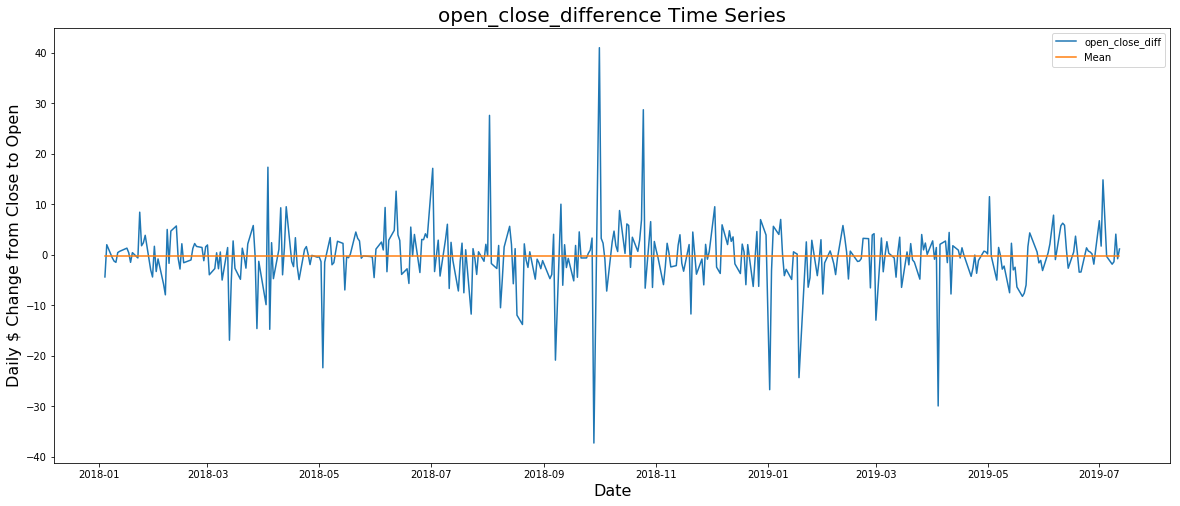

In [7]:
# View time series for open_close_diff

open_close_diff_mean = [np.mean(daily.open_close_diff)]*len(daily.open_close_diff)

fig, ax = plt.subplots(figsize=(20,8))

open_close_diff_line = ax.plot(daily.open_close_diff)
ax.set_title('open_close_difference Time Series', fontsize=20)
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel("Daily $ Change from Close to Open", fontsize=16)

mean_line = ax.plot(daily.open_close_diff.index,open_close_diff_mean, label='Mean')

legend = ax.legend(loc='upper right')

plt.show();

__Features of the plot__:
 - There appears to be no consistent trend throughout the time span. The mean is very close to zero and we see the data frequently crosses the mean line instead of staying on one side for that long.
 - There does not appear to be any seasonality within this time series.
 - There appears to be a few outliers, most noticably around October 2018.
 - Variance appears to be constant, despite a few outliers.

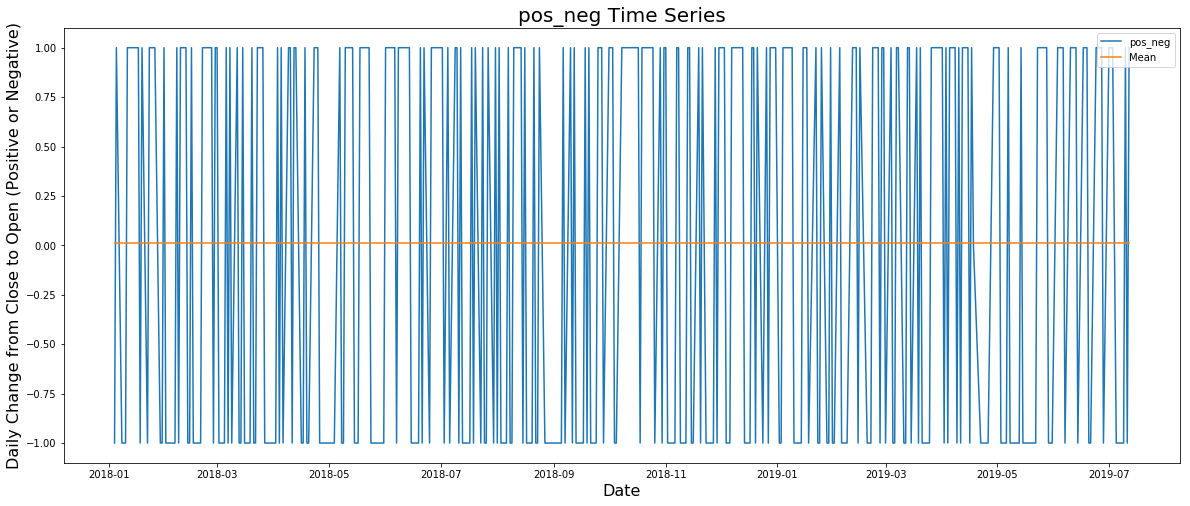

In [8]:
# View time series for open_close_diff

pos_neg_mean = [np.mean(daily.pos_neg)]*len(daily.pos_neg)

fig, ax = plt.subplots(figsize=(20,8))

pos_neg_line = ax.plot(daily.pos_neg)
ax.set_title('pos_neg Time Series', fontsize=20)
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel("Daily Change from Close to Open (Positive or Negative)", fontsize=16)

mean_line = ax.plot(daily.pos_neg.index,pos_neg_mean, label='Mean')

legend = ax.legend(loc='upper right')

plt.show();

__Features of the plot__: 
 - This graph is the same graph as the previous one, but instead of dollar amounts for the change in open and prior close stock price, only the direction is taken into account (+1 for a positive change, -1 for a negative change and 0 for a neutral change). This makes the graph a bit harder to interpret.
 - Although difficult to determine from this graph, there appears to be no consistent trend throughout the time span.
 - There does not appear to be any seasonality within this time series.
 - Due to the nature of this time series after classifying directions, outliers cannot be determined.
 - Variance appears to be constant.

In [9]:
# View line graphs for sentiment info series

#daily.sentiment_1.plot(figsize = (12,8), subplots=True, legend=True);       

In [10]:
# View line graphs for sentiment info series

#daily.sentiment_2.plot(figsize = (12,8), subplots=True, legend=True);  

## Stationarity

Statistical modeling methods assume time series to be stationary, that is, the mean and variance of the time series does not change over time. To ensure the target variables are stationary the Dickey-Fuller test will be used.

In [11]:
# Create function that uses the Dickey-Fuller Test to check that a series is stationary

def check_stationarity(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  

In [12]:
# Check if daily.open_close_diff is stationary

check_stationarity(daily.open_close_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -22.916022
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


Since the test p-value of the Dickey-Fuller is 0, it is assumed that open_close_diff is a stationary time series.

In [13]:
# Check if daily.pos_neg is stationary

check_stationarity(daily.pos_neg)

Results of Dickey-Fuller Test:
Test Statistic                 -19.939334
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


Since the test p-value of the Dickey-Fuller is 0, it is assumed that pos_neg is a stationary time series.

## ACF & PACF 

In [147]:
# Function to plot ACF and PACF for a timeseries

def plot_acf_pacf(timeseries):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    # Plot the ACF
    fig = sm.graphics.tsa.plot_acf(timeseries.iloc[1:], lags=18, ax=ax1)
    ax2 = fig.add_subplot(212)
    #plot the PACF
    fig = sm.graphics.tsa.plot_pacf(timeseries.iloc[1:], lags=18, ax=ax2)
    

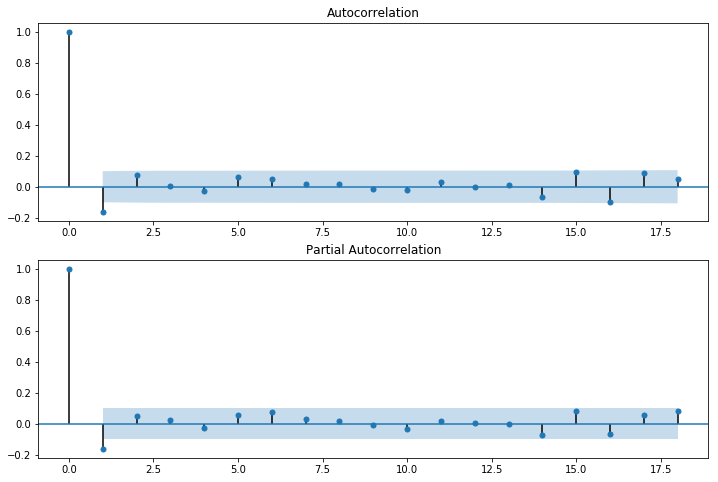

In [148]:
# Plot the ACF & PACF for open_close _diff

plot_acf_pacf(daily.open_close_diff)

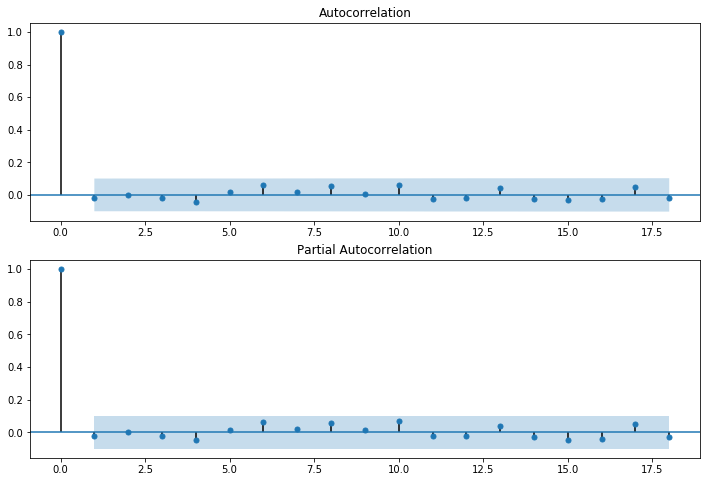

In [149]:
# Plot the ACF & PACF for pos_neg

plot_acf_pacf(daily.pos_neg)

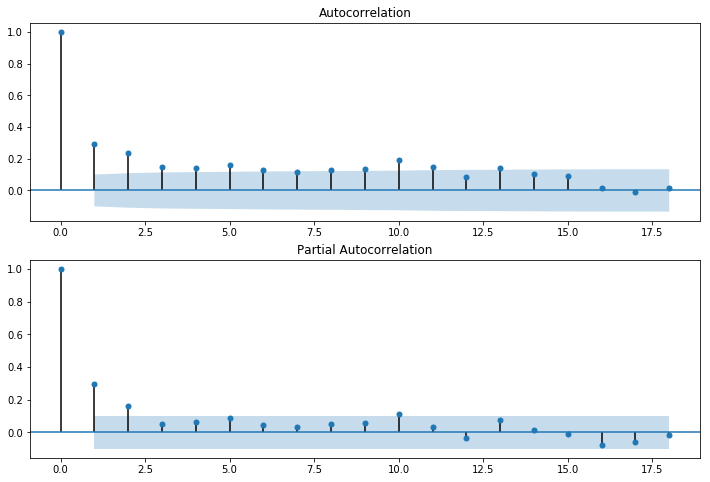

In [151]:
# Plot the ACF & PACF for sentiment_1

plot_acf_pacf(daily.sentiment_1)

# MODEL & PREDICT WITH ARIMAX

### Create Function to Plot Confusion Matrix

In [132]:
def plot_confusion_matrix(y_true, y_pred,endogenous, exongenous, cmap=plt.cm.Blues):
    title = endogenous + ' with ' + exongenous + ' Confusion Matrix'
    
    cm = confusion_matrix(y_true, y_pred)
    classes = sorted(set(y_true))
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

### Create Function that Creates Model and Predicts

In [133]:
def model_and_predict(endogenous, exongenous):
    
    # Create timeseries dataframe to model
    df = daily[[endogenous, exongenous]]
    
    # Split the dataset into training and testing datasets
    train_start,train_end = '2018-01-05','2019-02-25'
    test_start,test_end = '2019-02-26','2019-07-12'
    train = df[endogenous][train_start:train_end].dropna()
    test = df[endogenous][test_start:test_end].dropna()
    exog_train = df.drop([endogenous],axis = 1)[train_start:train_end].dropna()
    exog_test = df.drop([endogenous],axis = 1)[test_start:test_end].dropna()
    
    # Test different values of p, d an q to find which order gives the smallest Mean Absolute Error
    best_mae = float('inf')
    final_order = (0,0,0)
    for p in [0,1,2,3,4,5]:
        for d in [0,1,2,3,4,5]:
            for q in [0,1,2,3,4,5]:
                try:
                    order_test = (p,q,d)
                    arimax = sm.tsa.statespace.SARIMAX(train, order=order_test, 
                            seasonal_order=(0,0,0,0), exog=exog_train).fit()
                    if arimax.pvalues[0] < 0.1:
                        pred_test = arimax.predict(start=285, end=380, exog = exog_test)
                        mae = mean_absolute_error(test, pred_test)
                        if mae < best_mae:
                            best_mae = mae
                            final_order = order_test
                except:
                    continue
    print('Final order used in model: {}'.format(final_order))
    print('Best MAE : {}'.format(best_mae))
    print('\n')
    
    # Using the best order create final model
    model = sm.tsa.statespace.SARIMAX(train, order=final_order, seasonal_order=(0,0,0,0), exog=exog_train).fit()
    print(model.summary())
    print('\n')
    
    # Predict off of best model
    pred = model.predict(start=285, end=380, exog = exog_test)
    print('ARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))
    
    # Create predicition dataframe
    predictions_df = pd.DataFrame(pred, columns= ['predictions'])
    predictions_df.set_index(exog_test.index, inplace=True)
    predictions_df = pd.merge(pd.DataFrame(test), predictions_df, how='inner', left_index=True, right_index=True)
    
    # Turn prediction values into classification values (if the prediction is < 0, the class label will be -1; 
    # if the prediction is = 0, the class label will be 0; if the prediction is < 0, the class label will be 1)
    if endogenous == 'pos_neg':
        
        # Turn prediction values into classification values (if the prediction is < 0, the class label will be -1; 
        # if the prediction is = 0, the class label will be 0; if the prediction is < 0, the class label will be 1)
        predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >0) 
                                                                             else(-1 if x <0 else 0))
        
        print('Accuracy: ', accuracy_score(predictions_df[endogenous], predictions_df.class_predictions))
        
        # View model precision for classifying each class 
        # (will print as [precision for prediction class -1, precision for preiction class 0, precision for class 1])
        print('Precision: ', precision_score(predictions_df[endogenous], 
                                             predictions_df.class_predictions, average=None))
        
        # Call function to print confusion matrix
        plot_confusion_matrix(predictions_df[endogenous], predictions_df.class_predictions, endogenous, exongenous)
    
    else:
        
        # Turn open_close_diff into classification values (if the prediction is < 0, the class label will be -1; 
        # if the prediction is = 0, the class label will be 0; if the prediction is < 0, the class label will be 1)
        predictions_df[endogenous+'_class'] = predictions_df[endogenous].map(lambda x: 1 if (x >0) 
                                                                             else(-1 if x <0 else 0))
        
        # Turn prediction values into classification values (if the prediction is < 0, the class label will be -1; 
        # if the prediction is = 0, the class label will be 0; if the prediction is < 0, the class label will be 1)
        predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >-.3) 
                                                                             else(-1 if x <-.3 else 0))
        print(predictions_df['class_predictions'].mean())
        
        # View model precision for classifying each class 
        # (will print as [precision for prediction class -1, precision for preiction class 0, precision for class 1])
        print('Precision: ', precision_score(predictions_df[endogenous+'_class'], 
                                             predictions_df.class_predictions, average=None))
        
        # Call function to print confusion matrix
        plot_confusion_matrix(predictions_df[endogenous+'_class'], predictions_df.class_predictions, 
                              endogenous, exongenous)
    
    # View Maximum and Minimum actual and prediction values 
    print('\n')
    print('Max Test Value:', max(test))
    print('Min Test Value:', min(test))
    print('Max Prediction:', max(predictions_df.predictions))
    print('Min Prediction:', min(predictions_df.predictions))
    
    # View predicition dataframe
    return predictions_df.head(10)

### Model with open_close_diff & sentiment_1

Final order used in model: (3, 1, 4)
Best MAE : 3.2560087064581062


                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -941.106
Date:                Tue, 01 Oct 2019   AIC                           1900.212
Time:                        16:08:46   BIC                           1933.053
Sample:                             0   HQIC                          1913.379
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1   -14.7134      5.317     -2.767      0.006     -25.135      -4.292
ar.L1          -0.3629      0.497     -0.730      0.465    

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.483705,-1,-1
2019-02-27,3.920014,3.212611,1,1
2019-02-28,4.180023,0.007063,1,1
2019-03-01,-12.940003,-1.370149,-1,-1
2019-03-04,3.329986,-0.168452,1,1
2019-03-05,-3.359985,0.747065,-1,1
2019-03-06,-0.059998,0.801696,-1,1
2019-03-07,2.600006,-0.083020,1,1
2019-03-08,0.320008,1.032204,1,1


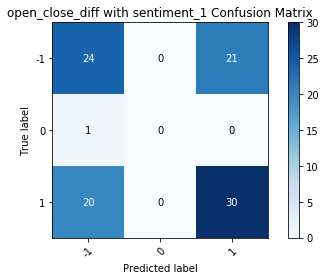

In [134]:
model_and_predict('open_close_diff', 'sentiment_1')

### Model with open_close_diff & sentiment_2

Final order used in model: (0, 0, 0)
Best MAE : inf


                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:                        SARIMAX   Log Likelihood                -944.721
Date:                Tue, 01 Oct 2019   AIC                           1893.442
Time:                        16:09:31   BIC                           1900.747
Sample:                             0   HQIC                          1896.370
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_2    -4.8243      6.400     -0.754      0.451     -17.369       7.720
sigma2         44.3337      1.458     30.413      0.000      41.477      4

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.321510,-1,-1
2019-02-27,3.920014,-0.002157,1,1
2019-02-28,4.180023,-0.263796,1,1
2019-03-01,-12.940003,-0.331485,-1,-1
2019-03-04,3.329986,-0.385718,1,-1
2019-03-05,-3.359985,-0.093012,-1,1
2019-03-06,-0.059998,-0.265480,-1,1
2019-03-07,2.600006,-0.086438,1,1
2019-03-08,0.320008,-0.179993,1,1


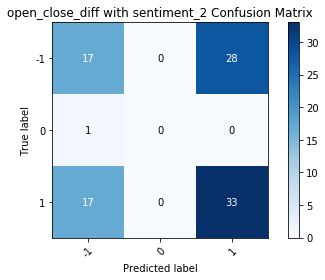

In [135]:
model_and_predict('open_close_diff', 'sentiment_2')

### Model with open_close_diff & s1_no_0

Final order used in model: (0, 1, 0)
Best MAE : 4.9143803852278864


                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1061.501
Date:                Tue, 01 Oct 2019   AIC                           2127.002
Time:                        16:10:11   BIC                           2134.300
Sample:                             0   HQIC                          2129.928
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_no_0      -14.1752      6.963     -2.036      0.042     -27.823      -0.528
sigma2       103.2840      3.925     26.315      0.000      95

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,4.294845,-1,1
2019-02-27,3.920014,7.357383,1,1
2019-02-28,4.180023,3.604684,1,1
2019-03-01,-12.940003,2.339762,-1,1
2019-03-04,3.329986,3.751468,1,1
2019-03-05,-3.359985,4.285276,-1,1
2019-03-06,-0.059998,4.913543,-1,1
2019-03-07,2.600006,4.092670,1,1
2019-03-08,0.320008,5.138989,1,1


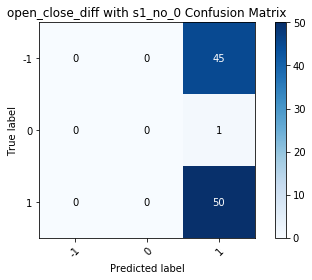

In [136]:
model_and_predict('open_close_diff', 's1_no_0')

### Model with open_close_diff & s2_no_0

Final order used in model: (3, 3, 0)
Best MAE : 1373.444504015777


                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 3, 0)   Log Likelihood               -1137.986
Date:                Tue, 01 Oct 2019   AIC                           2285.973
Time:                        16:10:56   BIC                           2304.182
Sample:                             0   HQIC                          2293.275
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_no_0      -13.4376      7.962     -1.688      0.091     -29.042       2.167
ar.L1         -1.6381      0.033    -49.077      0.000      -1.

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,7.348430,-1,1
2019-02-27,3.920014,12.317340,1,1
2019-02-28,4.180023,15.802845,1,1
2019-03-01,-12.940003,21.036483,-1,1
2019-03-04,3.329986,27.624748,1,1
2019-03-05,-3.359985,35.410893,-1,1
2019-03-06,-0.059998,42.899224,-1,1
2019-03-07,2.600006,52.510001,1,1
2019-03-08,0.320008,61.482598,1,1


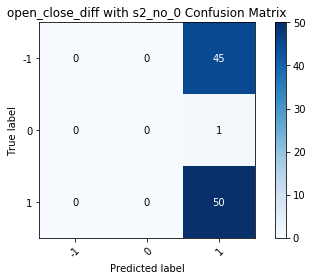

In [137]:
model_and_predict('open_close_diff', 's2_no_0')

### Model with open_close_diff & s1_scaled

Final order used in model: (0, 1, 0)
Best MAE : 5.127963930705228


                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1060.504
Date:                Tue, 01 Oct 2019   AIC                           2125.009
Time:                        16:11:35   BIC                           2132.307
Sample:                             0   HQIC                          2127.935
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_scaled     -7.1402      3.081     -2.318      0.020     -13.178      -1.102
sigma2       102.5670      4.275     23.994      0.000      94.

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,4.612941,-1,1
2019-02-27,3.920014,8.548833,1,1
2019-02-28,4.180023,4.020939,1,1
2019-03-01,-12.940003,2.466700,-1,1
2019-03-04,3.329986,3.946044,1,1
2019-03-05,-3.359985,4.813114,-1,1
2019-03-06,-0.059998,5.421731,-1,1
2019-03-07,2.600006,4.500639,1,1
2019-03-08,0.320008,5.668980,1,1


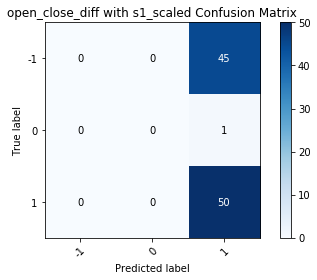

In [138]:
model_and_predict('open_close_diff', 's1_scaled')

### Model with open_close_diff & s2_scaled

Final order used in model: (2, 5, 1)
Best MAE : 68477.98746022987


                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(2, 5, 1)   Log Likelihood               -1307.483
Date:                Tue, 01 Oct 2019   AIC                           2624.966
Time:                        16:12:22   BIC                           2643.140
Sample:                             0   HQIC                          2632.255
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_scaled     -5.3007      3.057     -1.734      0.083     -11.292       0.691
ar.L1         -1.4372      0.030    -48.580      0.000      -1.

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,1.718414,-1,1
2019-02-27,3.920014,-4.719049,1,-1
2019-02-28,4.180023,-15.620425,1,-1
2019-03-01,-12.940003,-39.853487,-1,-1
2019-03-04,3.329986,-73.616237,1,-1
2019-03-05,-3.359985,-115.008058,-1,-1
2019-03-06,-0.059998,-171.414581,-1,-1
2019-03-07,2.600006,-242.575413,1,-1
2019-03-08,0.320008,-331.442515,1,-1


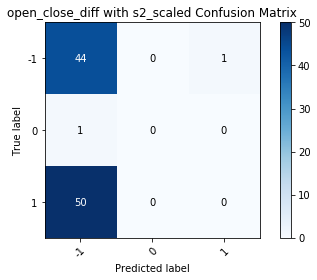

In [139]:
model_and_predict('open_close_diff', 's2_scaled')

### Model with pos_neg & sentiment_1

Final order used in model: (2, 2, 1)
Best MAE : 0.9416497995833856


                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -446.816
Date:                Tue, 01 Oct 2019   AIC                            903.632
Time:                        16:13:06   BIC                            921.860
Sample:                             0   HQIC                           910.941
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1    -1.7291      0.905     -1.911      0.056      -3.502       0.044
ar.L1          -0.6797      0.069     -9.909      0.000    

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.469887,1
2019-02-27,1.0,1.175538,1
2019-02-28,1.0,0.763242,1
2019-03-01,-1.0,0.575117,1
2019-03-04,1.0,0.763794,1
2019-03-05,-1.0,0.803062,1
2019-03-06,-1.0,0.846215,1
2019-03-07,1.0,0.792642,1
2019-03-08,1.0,0.875559,1


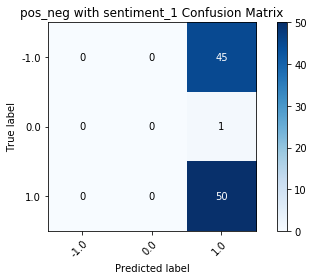

In [140]:
model_and_predict('pos_neg', 'sentiment_1')

### Model with pos_neg & sentiment_2

Final order used in model: (0, 0, 0)
Best MAE : inf


                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:                        SARIMAX   Log Likelihood                -404.368
Date:                Tue, 01 Oct 2019   AIC                            812.736
Time:                        16:13:50   BIC                            820.041
Sample:                             0   HQIC                           815.665
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_2     0.2236    125.549      0.002      0.999    -245.848     246.295
sigma2          0.9998    561.688      0.002      0.999   -1099.889    110

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.014903,1
2019-02-27,1.0,0.000100,1
2019-02-28,1.0,0.012228,1
2019-03-01,-1.0,0.015365,1
2019-03-04,1.0,0.017879,1
2019-03-05,-1.0,0.004311,1
2019-03-06,-1.0,0.012306,1
2019-03-07,1.0,0.004007,1
2019-03-08,1.0,0.008343,1


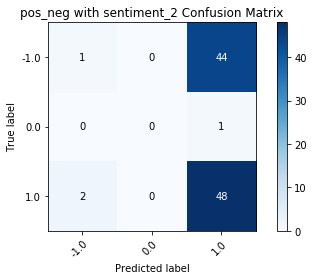

In [141]:
model_and_predict('pos_neg', 'sentiment_2')

### Model with pos_neg & s1_no_0

Final order used in model: (2, 2, 1)
Best MAE : 0.9407173438009894


                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -446.618
Date:                Tue, 01 Oct 2019   AIC                            903.236
Time:                        16:14:39   BIC                            921.463
Sample:                             0   HQIC                           910.544
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_no_0       -1.2871      0.634     -2.031      0.042      -2.529      -0.045
ar.L1         -0.6788      0.069     -9.863      0.000      -0

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.472895,1
2019-02-27,1.0,1.158783,1
2019-02-28,1.0,0.742214,1
2019-03-01,-1.0,0.557001,1
2019-03-04,1.0,0.762054,1
2019-03-05,-1.0,0.785753,1
2019-03-06,-1.0,0.841069,1
2019-03-07,1.0,0.780888,1
2019-03-08,1.0,0.872138,1


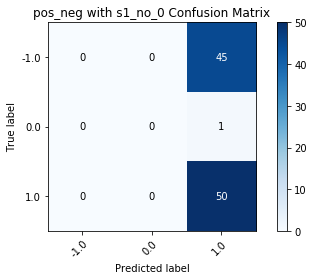

In [142]:
model_and_predict('pos_neg', 's1_no_0')

### Model with pos_neg & s2_no_0

Final order used in model: (3, 4, 0)
Best MAE : 4065.462048455436


                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(3, 4, 0)   Log Likelihood                -706.471
Date:                Tue, 01 Oct 2019   AIC                           1422.943
Time:                        16:15:21   BIC                           1441.134
Sample:                             0   HQIC                          1430.238
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_no_0       -2.2127      1.136     -1.949      0.051      -4.438       0.013
ar.L1         -1.7647      0.054    -32.948      0.000      -1.

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,4.488823,1
2019-02-27,1.0,7.201428,1
2019-02-28,1.0,11.136624,1
2019-03-01,-1.0,16.023767,1
2019-03-04,1.0,22.319140,1
2019-03-05,-1.0,29.142439,1
2019-03-06,-1.0,37.855955,1
2019-03-07,1.0,47.342512,1
2019-03-08,1.0,58.289327,1


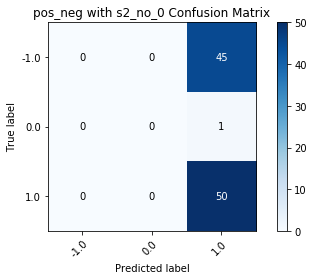

In [143]:
model_and_predict('pos_neg', 's2_no_0')

### Model with pos_neg & s1_scaled

Final order used in model: (2, 2, 1)
Best MAE : 0.9416728304198004


                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -446.816
Date:                Tue, 01 Oct 2019   AIC                            903.632
Time:                        16:16:01   BIC                            921.859
Sample:                             0   HQIC                           910.941
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1_scaled     -0.5316      0.278     -1.915      0.056      -1.076       0.013
ar.L1         -0.6797      0.069     -9.909      0.000      -0

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,0.470158,1
2019-02-27,1.0,1.176281,1
2019-02-28,1.0,0.763352,1
2019-03-01,-1.0,0.575036,1
2019-03-04,1.0,0.763892,1
2019-03-05,-1.0,0.803297,1
2019-03-06,-1.0,0.846545,1
2019-03-07,1.0,0.792830,1
2019-03-08,1.0,0.875921,1


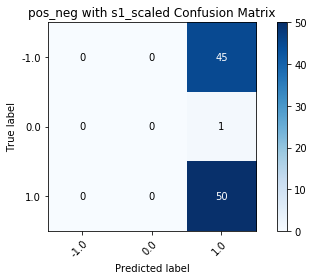

In [144]:
model_and_predict('pos_neg', 's1_scaled')

### Model with pos_neg & s2_scaled

Final order used in model: (0, 4, 0)
Best MAE : 146034.87897209844


                           Statespace Model Results                           
Dep. Variable:                pos_neg   No. Observations:                  285
Model:               SARIMAX(0, 4, 0)   Log Likelihood               -1004.363
Date:                Tue, 01 Oct 2019   AIC                           2012.727
Time:                        16:16:40   BIC                           2020.004
Sample:                             0   HQIC                          2015.645
                                - 285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s2_scaled      0.6522      0.388      1.680      0.093      -0.109       1.413
sigma2        74.4867      8.014      9.295      0.000      58

,pos_neg,predictions,class_predictions
Date,,,
2019-02-26,-1.0,-4.168136,-1
2019-02-27,1.0,-18.629431,-1
2019-02-28,1.0,-46.044296,-1
2019-03-01,-1.0,-89.062432,-1
2019-03-04,1.0,-152.381651,-1
2019-03-05,-1.0,-239.660601,-1
2019-03-06,-1.0,-354.219463,-1
2019-03-07,1.0,-499.743727,-1
2019-03-08,1.0,-679.770458,-1


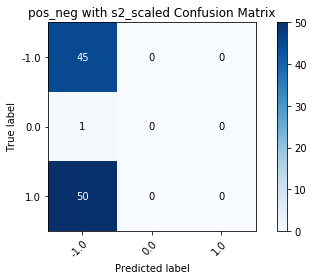

In [145]:
model_and_predict('pos_neg', 's2_scaled')

## BEST MODEL:

Final order used in model: (3, 1, 4)
Best MAE : 3.2560087064581062


                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -941.106
Date:                Tue, 01 Oct 2019   AIC                           1900.212
Time:                        15:25:59   BIC                           1933.053
Sample:                             0   HQIC                          1913.379
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1   -14.7134      5.317     -2.767      0.006     -25.135      -4.292
ar.L1          -0.3629      0.497     -0.730      0.465    

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.483705,-1,-1
2019-02-27,3.920014,3.212611,1,1
2019-02-28,4.180023,0.007063,1,1
2019-03-01,-12.940003,-1.370149,-1,-1
2019-03-04,3.329986,-0.168452,1,-1
2019-03-05,-3.359985,0.747065,-1,1
2019-03-06,-0.059998,0.801696,-1,1
2019-03-07,2.600006,-0.083020,1,-1
2019-03-08,0.320008,1.032204,1,1


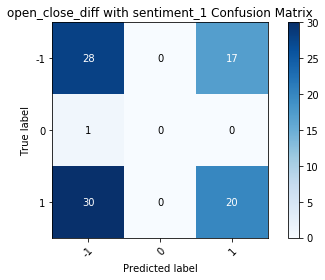

In [97]:
model_and_predict('open_close_diff', 'sentiment_1')

In [170]:
def model_and_predict_final(endogenous, exongenous):
    
    # Create timeseries dataframe to model
    df = daily[[endogenous, exongenous]]
    
    # Split the dataset into training and testing datasets
    train_start,train_end = '2018-01-05','2019-02-25'
    test_start,test_end = '2019-02-26','2019-07-12'
    train = df[endogenous][train_start:train_end].dropna()
    test = df[endogenous][test_start:test_end].dropna()
    exog_train = df.drop([endogenous],axis = 1)[train_start:train_end].dropna()
    exog_test = df.drop([endogenous],axis = 1)[test_start:test_end].dropna()
    
    # Using the best order create final model
    model = sm.tsa.statespace.SARIMAX(train, order=(3,1,4), seasonal_order=(0,0,0,0), exog=exog_train).fit()
    print(model.summary())
    print('\n')
    
    # Predict off of best model
    pred = model.predict(start=285, end=380, exog = exog_test)
    print('ARIMAX model MSE:{}'.format(mean_squared_error(test,pred)))
    print('\n')
    
    # Create predicition dataframe
    predictions_df = pd.DataFrame(pred, columns= ['predictions'])
    predictions_df.set_index(exog_test.index, inplace=True)
    predictions_df = pd.merge(pd.DataFrame(test), predictions_df, how='inner', left_index=True, right_index=True)
        
    # Turn open_close_diff into classification values (if the prediction is < 0, the class label will be -1; 
    # if the prediction is = 0, the class label will be 0; if the prediction is < 0, the class label will be 1)
    predictions_df[endogenous+'_class'] = predictions_df[endogenous].map(lambda x: 1 if (x >0) else(-1 if x <0 else 0))    
        
    final_cutoff = 0
    best_precision = 0
    for co in [0, -.1, -.2, -.3, -.4]:
        try:
            cut_off = co
            test = predictions_df.predictions.map(lambda x: 1 if (x >co) else(-1 if x <co else 0))
            if precision_score(predictions_df[endogenous+'_class'], test, average=None)[2] > best_precision:
                best_precision = precision_score(predictions_df[endogenous+'_class'], test, average=None)[2]
                final_cutoff = cut_off
        except:
            continue
        
    predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >final_cutoff) 
                                                                         else(-1 if x <final_cutoff else 0))
    
    print('Final cutt-off: ', final_cutoff)
    print('\n')
            
            
        
        
    # Turn prediction values into classification values (if the prediction is < 0, the class label will be -1; 
    # if the prediction is = 0, the class label will be 0; if the prediction is < 0, the class label will be 1)
    #predictions_df['class_predictions'] = predictions_df.predictions.map(lambda x: 1 if (x >-.0) else(-1 if x <-.0 else 0))
    #print(predictions_df['class_predictions'].mean())
        
    # View model precision for classifying each class 
    # (will print as [precision for prediction class -1, precision for preiction class 0, precision for class 1])
    print('Precision: ', precision_score(predictions_df[endogenous+'_class'], predictions_df.class_predictions, average=None))
        
    # Call function to print confusion matrix
    plot_confusion_matrix(predictions_df[endogenous+'_class'], predictions_df.class_predictions, endogenous, exongenous)
    
    # View Maximum and Minimum actual and prediction values 
    print('\n')
    print('Max Test Value:', max(test))
    print('Min Test Value:', min(test))
    print('Max Prediction:', max(predictions_df.predictions))
    print('Min Prediction:', min(predictions_df.predictions))
    
    # View predicition dataframe
    return predictions_df.head(10)

                           Statespace Model Results                           
Dep. Variable:        open_close_diff   No. Observations:                  285
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -941.106
Date:                Tue, 01 Oct 2019   AIC                           1900.212
Time:                        17:11:32   BIC                           1933.053
Sample:                             0   HQIC                          1913.379
                                - 285                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sentiment_1   -14.7134      5.317     -2.767      0.006     -25.135      -4.292
ar.L1          -0.3629      0.497     -0.730      0.465      -1.337       0.611
ar.L2          -1.0146      0.199     -5.110    

,open_close_diff,predictions,open_close_diff_class,class_predictions
Date,,,,
2019-02-26,-6.549988,-0.483705,-1,-1
2019-02-27,3.920014,3.212611,1,1
2019-02-28,4.180023,0.007063,1,1
2019-03-01,-12.940003,-1.370149,-1,-1
2019-03-04,3.329986,-0.168452,1,1
2019-03-05,-3.359985,0.747065,-1,1
2019-03-06,-0.059998,0.801696,-1,1
2019-03-07,2.600006,-0.083020,1,1
2019-03-08,0.320008,1.032204,1,1


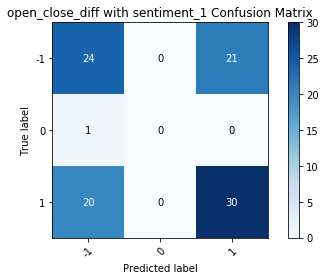

In [171]:
model_and_predict_final('open_close_diff', 'sentiment_1')